In [26]:
#Libraries.
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("weather_classification_data.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [3]:
df.shape

(13200, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [6]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


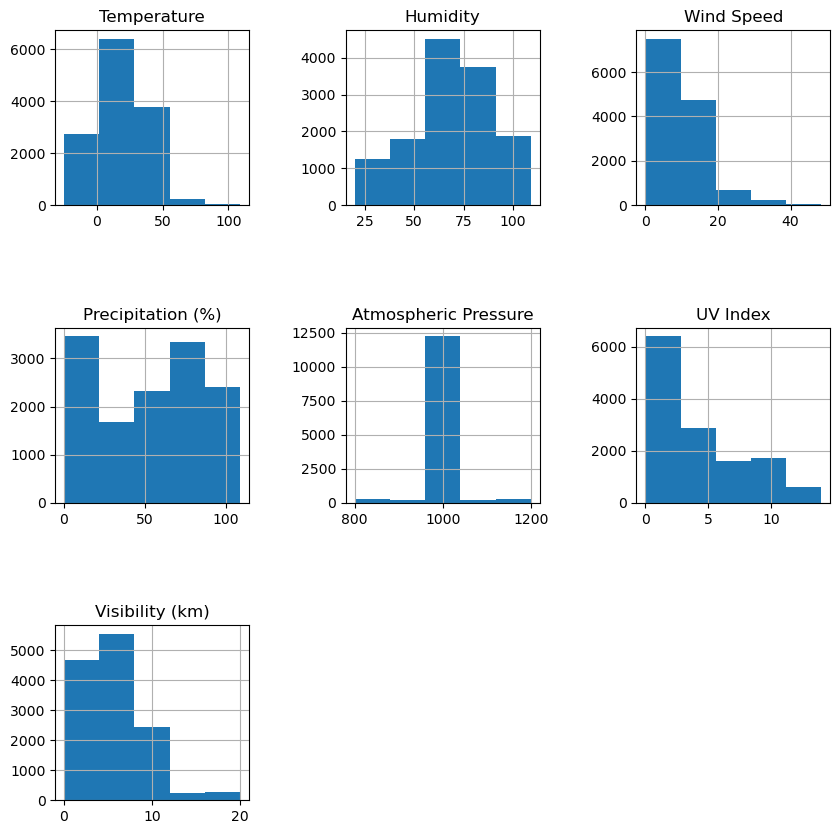

In [7]:
fig = df.hist(figsize=(10,10), bins=5)
plt.subplots_adjust(hspace=.7,wspace=.5)
plt.show();

<Axes: >

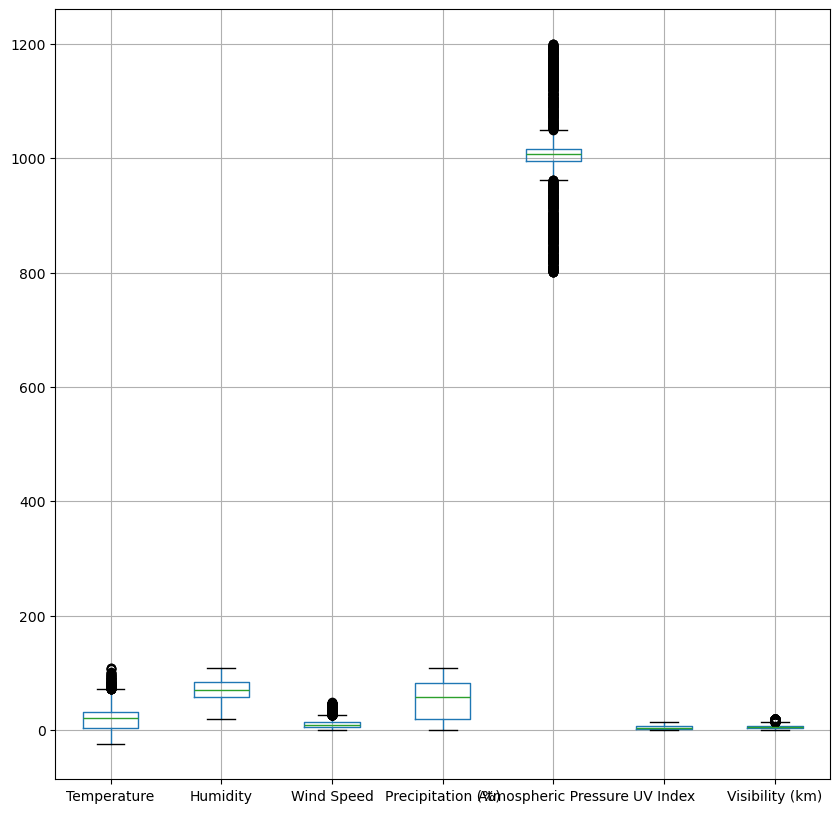

In [8]:
df.boxplot(figsize=(10,10))

In [ ]:
#Temperature, Wind Speed, Atmospheric Pressure and Visibility (km) have outliers.

In [9]:
def iqr(df, col):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3-Q1
    lower_limit = Q1-1.5*IQR
    upper_limit = Q3+1.5*IQR
    return df[col].between(lower_limit,upper_limit)

In [10]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Weather Type'],
      dtype='object')

In [11]:
def wrangle(filepath):
    #Read dataset
    df = pd.read_csv(filepath)
    #Remove the outliers.
    cols = ["Temperature", "Wind Speed", "Atmospheric Pressure","Visibility (km)"]
    mask = pd.Series(True, index=df.index)
    for col in cols:
        m = iqr(df, col)
        mask &= m
    return df[mask]

In [12]:
df_cleaned = wrangle("weather_classification_data.csv")
df_cleaned.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [13]:
df_cleaned.shape

(11689, 11)

In [14]:
df_cleaned = pd.get_dummies(df_cleaned, columns=["Location", "Season", "Cloud Cover"], dtype=int)
df_cleaned.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Weather Type,Location_coastal,Location_inland,Location_mountain,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy
0,14.0,73,9.5,82.0,1010.82,2,3.5,Rainy,0,1,0,0,0,0,1,0,0,0,1
1,39.0,96,8.5,71.0,1011.43,7,10.0,Cloudy,0,1,0,0,1,0,0,0,0,0,1
2,30.0,64,7.0,16.0,1018.72,5,5.5,Sunny,0,0,1,0,1,0,0,1,0,0,0
3,38.0,83,1.5,82.0,1026.25,7,1.0,Sunny,1,0,0,0,1,0,0,1,0,0,0
4,27.0,74,17.0,66.0,990.67,1,2.5,Rainy,0,0,1,0,0,0,1,0,0,1,0


In [15]:
df_cleaned.isnull().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
Precipitation (%)            0
Atmospheric Pressure         0
UV Index                     0
Visibility (km)              0
Weather Type                 0
Location_coastal             0
Location_inland              0
Location_mountain            0
Season_Autumn                0
Season_Spring                0
Season_Summer                0
Season_Winter                0
Cloud Cover_clear            0
Cloud Cover_cloudy           0
Cloud Cover_overcast         0
Cloud Cover_partly cloudy    0
dtype: int64

In [16]:
df_cleaned.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)', 'Weather Type',
       'Location_coastal', 'Location_inland', 'Location_mountain',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast',
       'Cloud Cover_partly cloudy'],
      dtype='object')

In [17]:
#Feature and matrix
Features = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)',
       'Location_coastal', 'Location_inland', 'Location_mountain',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast',
       'Cloud Cover_partly cloudy']
X = df_cleaned[Features]
y = df_cleaned["Weather Type"]
print(X.shape)
print(y.shape)

(11689, 18)
(11689,)


In [18]:
#Splitting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("t_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9351, 18)
X_test shape: (2338, 18)
t_train shape: (9351,)
y_test shape: (2338,)


In [19]:
#Instantiiate the RandomForestClassifier.
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

In [20]:
rf_classifier.fit(X_train,y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_pred = rf_classifier.predict(X_test)

In [23]:
acc_score = accuracy_score(y_test,y_pred)
print(f"Overall accuracy: {acc_score:.4f}")

Overall accuracy: 0.9756


In [25]:
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.95      0.97      0.96       615
       Rainy       0.97      0.96      0.97       554
       Snowy       1.00      0.98      0.99       571
       Sunny       0.99      0.98      0.99       598

    accuracy                           0.98      2338
   macro avg       0.98      0.98      0.98      2338
weighted avg       0.98      0.98      0.98      2338



In [27]:
model_filename = "weather_prediction_type.joblib"

In [ ]:
#Saving the model.
joblib.dump(rf_classifier, )